## 0. loading packages 

In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import itertools
from scipy import stats

In [3]:
def generate_data_v2(n, rho,beta_v=[10]):
    p = len(beta_v)
    mean = np.zeros(p) # assume all centered at 0
    beta = np.array(beta_v)
    
    cov = np.ones((p,p))*rho
    np.fill_diagonal(cov, 1)
    
    X = np.random.multivariate_normal(mean, cov, n)
    y = X @ beta + np.random.normal(0,1,n)
    return X,y

## 1. linear regression (least squares)

In [4]:
# model0: beta1
# model1: beta1, beta2
# model2: beta1, beta2, beta3
# ... 
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

def cv_vs_cd_exact_lr(X,y,kfold):
    n = X.shape[0]
    p = X.shape[1]
    X = np.concatenate([np.ones((n,1)),X],axis=1)
    fold = n//kfold
    #### info we need 
    cv_error_v = []
    cd_error_v = []
    aic_v = []
    bic_v = []
    
    for p0 in range(p+1):
        X_ = X[:,np.arange(p0+1)]
        H = X_ @ np.linalg.inv(X_.T @ X_) @ X_.T
        reg = OLS(y, add_constant(X_)).fit()
        aic_v.append(reg.aic)
        bic_v.append(reg.bic)
        y_hat = H @ y
        cd_error = 0
        cv_error = 0
        cd_est = 0

        
        for i in range(kfold):
            mask = np.ones(n, dtype=bool)
            indices = np.arange(i*fold, (i+1)*fold)
            sub_H = H[np.ix_(indices, indices)]
            step = np.linalg.inv(np.eye(fold)-sub_H) 
            #### cd error
            cd_error += (y_hat[indices]-y[indices]) @ step @ sub_H @ step @ (y_hat[indices]-y[indices])
            #### cv error 
            cv_error += np.sum((step @ (y_hat[indices]-y[indices]))**2)
            
        cv_error_v.append(cv_error)
        cd_error_v.append(cd_error)
    return pd.DataFrame(data = {'cv_error':cv_error_v, 'cd_error': cd_error_v,
                                'new_error': [cv_error_v[i]+cd_error_v[i]*np.sqrt(n) for i in range(p+1)],
                               'aic':aic_v,'bic':bic_v})
    

Text(0.5, 0, 'Number of covariates in')

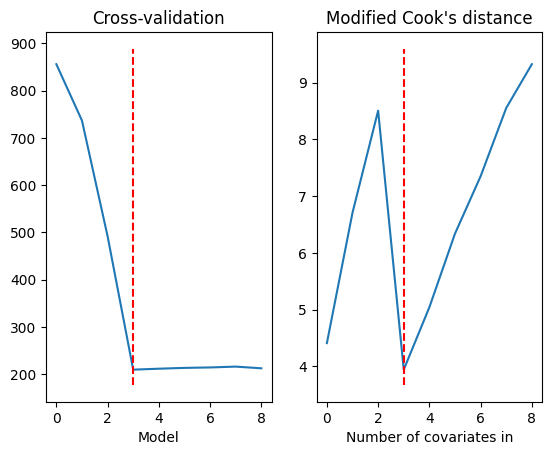

In [25]:
np.random.seed(100)
X_train, y_train= generate_data_v2(200,0.,[1,1,1,0,0,0,0,0])
# X_train2 = X_train - np.mean(X_train,0)
df = cv_vs_cd_exact_lr(X_train, y_train,100)
fig,ax = plt.subplots(1,2,sharex=True)
ax[0].plot(df.cv_error)
ymin, ymax =ax[0].get_ylim()
ax[0].vlines(3, ymin, ymax, linestyle="dashed",color='red')
ax[0].set_title('Cross-validation')
ax[0].set_xlabel("Model")
ax[1].plot(df.cd_error)
ymin, ymax =ax[1].get_ylim()
ax[1].set_title("Modified Cook's distance")
ax[1].vlines(3, ymin, ymax, linestyle="dashed",color='red')
ax[1].set_xlabel("Number of covariates in")

In [ ]:
cd_choice = []
cv_choice = []
cx_choice = []
aic_choice = []
bic_choice = []
true_beta = [0.5,0.5,0.5,0,0,0,0]
for i in range(100):
    X_train, y_train= generate_data_v2(200,0.,true_beta)
    # X_train2 = X_train - np.mean(X_train,0)
    a,b,c,d,e = cv_vs_cd_exact_lr(X_train, y_train,10).idxmin().to_numpy()
    cv_choice.append(a)
    cd_choice.append(b)
    cx_choice.append(c)
    aic_choice.append(d)
    bic_choice.append(e)
    # cd_est_choice.append(d)
# print(sum(np.array(cv_choice)==2), sum(np.array(cd_choice)==2),sum(np.array(cx_choice)==2))

# plt.bar_label(bars)

fig,ax = plt.subplots(5,1,sharex=True)
counts, edges, bars = ax[0].hist(cv_choice,bins=np.arange(0, len(true_beta) + 2, 1)-0.5,edgecolor="yellow")
ax[0].bar_label(bars)
ax[0].set_title('CV')
counts, edges, bars = ax[1].hist(cd_choice,bins=np.arange(0, len(true_beta) + 2, 1)-0.5,edgecolor="yellow",color='green')
ax[1].bar_label(bars)
ax[1].set_title('CD')
counts, edges, bars = ax[2].hist(cx_choice,bins=np.arange(0, len(true_beta) + 2, 1)-0.5,edgecolor="yellow",color='red')
ax[2].bar_label(bars)
ax[2].set_title('ARC')
counts, edges, bars = ax[3].hist(aic_choice,bins=np.arange(0, len(true_beta) + 2, 1)-0.5,edgecolor="yellow",color='orange')
ax[3].bar_label(bars)
ax[3].set_title('AIC')
counts, edges, bars = ax[4].hist(bic_choice,bins=np.arange(0, len(true_beta) + 2, 1)-0.5,edgecolor="yellow",color='purple')
ax[4].bar_label(bars)
ax[4].set_title('BIC')
plt.text(0.1, .95, f'True model: {true_beta}', ha='left', va='top', transform=ax[2].transAxes)

In [40]:
cv_vs_cd_exact_lr(X_train,y_train, n)

,cv_error,cd_error,new_error,aic,bic
0,129.260246,2.585205,147.540405,189.363821,191.275844
1,83.212966,3.075774,104.961976,167.610571,171.434617
2,70.716636,4.040311,99.285952,159.382480,165.118549
3,43.515994,3.670017,69.466934,134.244983,141.893075
4,44.309032,4.469605,75.913915,135.342826,144.902941
5,45.662679,5.353858,83.520170,137.038557,148.510695
6,47.230799,6.964379,96.476395,137.293810,150.677971
7,49.079539,8.430796,108.694272,138.355513,153.651697


In [36]:
np.random.seed(100)
true_beta = [[2,2, 2, 0, 0, 0, 0], [0.5, 0.5, 0.5, 0, 0, 0, 0]]
samplesize = [200, 50]
cor = [0, 0.2, 0.5]
fold = ['loo',5]
comb = list(itertools.product(true_beta, samplesize, fold,cor))

result = np.zeros((len(comb), 8))
iter = 0
setting = []
for tb, n, f,r in comb:
    setting.append(str(tb)+str(n)+str(f)+str(r))
    ans = []
    if f == 'loo':
        for i in range(500):
            X_train, y_train= generate_data_v2(n, r, tb)
            ans.append(cv_vs_cd_exact_lr(X_train,y_train, n).idxmin().to_numpy()[[0,2,3,4]]/3)
    else:
        for i in range(50):
            X_train, y_train= generate_data_v2(n, r, tb)
            ans.append(cv_vs_cd_exact_lr(X_train,y_train, f).idxmin().to_numpy()[[0,2,3,4]]/3)
    result[iter,0:4] = np.array(ans).mean(0)
    result[iter,4:8] = np.array(ans).std(0)
    iter+=1

In [41]:
columns = ['cv', 'arc','aic','bic', 'cv_std', 'arc_std','aic_std','bic_std']
df = pd.DataFrame(columns=columns, data=result)

In [42]:
df['setting'] = setting

In [43]:
df

,cv,arc,aic,bic,cv_std,arc_std,aic_std,bic_std,setting
0,1.246667,1.000000,1.200000,1.020000,0.409932,0.000000,0.371184,0.103494,"[2, 2, 2, 0, 0, 0, 0]200loo0"
1,1.133333,1.000000,1.153333,1.026667,0.290593,0.000000,0.307029,0.112349,"[2, 2, 2, 0, 0, 0, 0]200loo0.2"
2,1.200000,1.000000,1.240000,1.026667,0.339935,0.000000,0.388959,0.090431,"[2, 2, 2, 0, 0, 0, 0]200loo0.5"
3,1.233333,1.006667,1.206667,1.006667,0.384419,0.046667,0.339215,0.046667,"[2, 2, 2, 0, 0, 0, 0]20050"
4,1.313333,1.006667,1.233333,1.006667,0.402271,0.046667,0.354338,0.046667,"[2, 2, 2, 0, 0, 0, 0]20050.2"
5,1.253333,1.026667,1.193333,1.006667,0.356277,0.112349,0.359568,0.046667,"[2, 2, 2, 0, 0, 0, 0]20050.5"
6,1.126667,1.006667,1.173333,1.026667,0.297321,0.046667,0.378535,0.146667,"[2, 2, 2, 0, 0, 0, 0]50loo0"
7,1.153333,1.006667,1.226667,1.020000,0.276566,0.046667,0.391237,0.079162,"[2, 2, 2, 0, 0, 0, 0]50loo0.2"
8,1.086667,1.006667,1.146667,1.013333,0.197878,0.046667,0.313829,0.093333,"[2, 2, 2, 0, 0, 0, 0]50loo0.5"
9,1.213333,1.046667,1.246667,1.046667,0.318050,0.133500,0.387642,0.210924,"[2, 2, 2, 0, 0, 0, 0]5050"


## 2. Lasso 

In [46]:
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

def cv_vs_cd_exact_ls(X,y,kfold):
    # alpha_v, nov, coefs = linear_model.lars_path(X, y, method='lasso')
    reg = LassoLarsIC(criterion='aic')
    reg.fit(X,y)
    alpha_v = reg.alphas_
    aic_v = reg.criterion_
    reg = LassoLarsIC(criterion='bic')
    reg.fit(X,y)
    bic_v = reg.criterion_
    
    # nov.append(X.shape[1])
    n = X.shape[0]
    fold = n//kfold
    #### info we need 
    cv_error_v = []
    cd_error_v = []
    cx_error_v = []
    
    ols = linear_model.LinearRegression()
    denom = sum(np.abs(ols.fit(X,y).coef_))
    est_beta = []
    for alpha in alpha_v:
        reg = linear_model.LassoLars(alpha=alpha)
        reg.fit(X,y)
        y_hat = reg.predict(X)
        # est_beta.append(np.round(reg.coef_,5))
        est_beta.append(sum(np.abs(reg.coef_))/denom)
        
        
        cv_error = 0
        cd_error = 0
        
        for i in range(kfold):
            mask = np.ones(n, dtype=bool)
            indices = np.arange(i*fold, (i+1)*fold)
            mask[indices] = False 
            
            reg.fit(X[mask,:], y[mask])
            y_hat_k = reg.predict(X)
            
            #### cd error
            cd_error += np.sum((y_hat-y_hat_k)**2)
            
            #### cv error 
            cv_error += np.sum((y[indices]-y_hat_k[indices])**2)
        cv_error_v.append(cv_error)
        cd_error_v.append(cd_error)
        cx_error_v.append(cv_error+np.sqrt(n)*cd_error/2)
        # cd_error_v.append(cd_error)
    # print(nov, cv_error_v,alpha_v)
    df = pd.DataFrame(data = {'alpha':alpha_v, 'cv_error':cv_error_v, 'cd_error': cd_error_v, 'cx_error':cx_error_v})
    # df = df.sort_values(by=df.columns[-1], ascending=True)
    df['aic'] = aic_v
    df['bic'] = bic_v
    df['frac'] = est_beta
    return df                                # 'estimated_intercept':est_intercept})

In [47]:
import itertools
np.random.seed(100)
true_beta = [[2,2, 2, 0, 0, 0, 0], [0.5, 0.5, 0.5, 0, 0, 0, 0]]
samplesize = [200, 50]
cor = [0, 0.2, 0.5]
fold = ['loo',5]
comb = list(itertools.product(true_beta, samplesize, fold,cor))
result = np.zeros((len(comb), 8))
iter = 0
setting = []
for tb, n, f,r in comb:
    setting.append(str(tb)+str(n)+str(f)+str(r))
    ans = []
    if f == 'loo':
        for i in range(10):
            X_train, y_train= generate_data_v2(n, r, tb)
            ans.append(cv_vs_cd_exact_ls(X_train,y_train, n).idxmin().to_numpy()[[1,3,4,5]]/3)
    else:
        for i in range(10):
            X_train, y_train= generate_data_v2(n, r, tb)
            ans.append(cv_vs_cd_exact_ls(X_train,y_train, f).idxmin().to_numpy()[[1,3,4,5]]/3)
    result[iter,0:4] = np.array(ans).mean(0)
    result[iter,4:8] = np.array(ans).std(0)
    iter+=1

[2, 2, 2, 0, 0, 0, 0] 200 loo 0
[2, 2, 2, 0, 0, 0, 0] 200 loo 0.2
[2, 2, 2, 0, 0, 0, 0] 200 loo 0.5
[2, 2, 2, 0, 0, 0, 0] 200 5 0
[2, 2, 2, 0, 0, 0, 0] 200 5 0.2
[2, 2, 2, 0, 0, 0, 0] 200 5 0.5
[2, 2, 2, 0, 0, 0, 0] 50 loo 0
[2, 2, 2, 0, 0, 0, 0] 50 loo 0.2
[2, 2, 2, 0, 0, 0, 0] 50 loo 0.5
[2, 2, 2, 0, 0, 0, 0] 50 5 0
[2, 2, 2, 0, 0, 0, 0] 50 5 0.2
[2, 2, 2, 0, 0, 0, 0] 50 5 0.5
[0.5, 0.5, 0.5, 0, 0, 0, 0] 200 loo 0
[0.5, 0.5, 0.5, 0, 0, 0, 0] 200 loo 0.2
[0.5, 0.5, 0.5, 0, 0, 0, 0] 200 loo 0.5
[0.5, 0.5, 0.5, 0, 0, 0, 0] 200 5 0
[0.5, 0.5, 0.5, 0, 0, 0, 0] 200 5 0.2
[0.5, 0.5, 0.5, 0, 0, 0, 0] 200 5 0.5
[0.5, 0.5, 0.5, 0, 0, 0, 0] 50 loo 0
[0.5, 0.5, 0.5, 0, 0, 0, 0] 50 loo 0.2
[0.5, 0.5, 0.5, 0, 0, 0, 0] 50 loo 0.5
[0.5, 0.5, 0.5, 0, 0, 0, 0] 50 5 0
[0.5, 0.5, 0.5, 0, 0, 0, 0] 50 5 0.2
[0.5, 0.5, 0.5, 0, 0, 0, 0] 50 5 0.5


In [48]:
columns = ['cv', 'arc','aic','bic', 'cv_std', 'arc_std','aic_std','bic_std']
df = pd.DataFrame(columns=columns, data=result)
df['setting'] = setting
df

,cv,arc,aic,bic,cv_std,arc_std,aic_std,bic_std,setting
0,1.666667,1.200000,1.600000,1.200000,0.421637,0.305505,0.359011,0.305505,"[2, 2, 2, 0, 0, 0, 0]200loo0"
1,1.533333,1.233333,1.500000,1.333333,0.498888,0.334996,0.453382,0.394405,"[2, 2, 2, 0, 0, 0, 0]200loo0.2"
2,1.466667,1.300000,1.400000,1.300000,0.498888,0.406885,0.416333,0.406885,"[2, 2, 2, 0, 0, 0, 0]200loo0.5"
3,1.633333,1.100000,1.633333,1.466667,0.433333,0.152753,0.406885,0.426875,"[2, 2, 2, 0, 0, 0, 0]20050"
4,1.700000,1.066667,1.633333,1.100000,0.406885,0.133333,0.504425,0.152753,"[2, 2, 2, 0, 0, 0, 0]20050.2"
5,1.466667,1.300000,1.500000,1.266667,0.163299,0.233333,0.166667,0.249444,"[2, 2, 2, 0, 0, 0, 0]20050.5"
6,1.666667,1.366667,1.666667,1.400000,0.394405,0.348010,0.394405,0.326599,"[2, 2, 2, 0, 0, 0, 0]50loo0"
7,1.700000,1.533333,1.633333,1.433333,0.406885,0.400000,0.458258,0.366667,"[2, 2, 2, 0, 0, 0, 0]50loo0.2"
8,1.800000,1.600000,1.766667,1.600000,0.748331,0.771722,0.746101,0.742369,"[2, 2, 2, 0, 0, 0, 0]50loo0.5"
9,1.800000,1.600000,1.633333,1.400000,0.476095,0.442217,0.433333,0.359011,"[2, 2, 2, 0, 0, 0, 0]5050"


## 3. Ridge regression 

In [52]:
# model0: beta1
# model1: beta1, beta2
# model2: beta1, beta2, beta3
# ...
from sklearn.linear_model import Ridge
def cv_vs_cd_exact_rg(X,y,kfold,alpha_v):
    # alpha_v, nov, coefs = linear_model.lars_path(X, y, method='lasso')
    reg = Ridge(alpha=1.0)
    
    # nov.append(X.shape[1])
    n = X.shape[0]
    fold = n//kfold
    #### info we need 
    cv_error_v = []
    cd_error_v = []
    cx_error_v = []
    
    ols = linear_model.LinearRegression()
    denom = sum(np.abs(ols.fit(X,y).coef_))
    frac_beta = []
    premse = []
    for alpha in alpha_v:
        reg = linear_model.Ridge(alpha=alpha)
        reg.fit(X,y)
        y_hat = reg.predict(X)
        # est_beta.append(np.round(reg.coef_,5))
        # print(reg.coef_)
        frac_beta.append(sum(np.abs(reg.coef_))/denom)
        premse.append( reg.coef_ )
        
        # est_intercept.append(reg.intercept_)
        
        cv_error = 0
        cd_error = 0
        
        for i in range(kfold):
            mask = np.ones(n, dtype=bool)
            indices = np.arange(i*fold, (i+1)*fold)
            mask[indices] = False 
            
            reg.fit(X[mask,:], y[mask])
            y_hat_k = reg.predict(X)
            
            #### cd error
            cd_error += np.sum((y_hat-y_hat_k)**2)
            
            #### cv error 
            cv_error += np.sum((y[indices]-y_hat_k[indices])**2)
        cv_error_v.append(cv_error)
        cd_error_v.append(cd_error)
        cx_error_v.append(cv_error+np.sqrt(n)*cd_error/2)
        # cd_error_v.append(cd_error)
    df = pd.DataFrame(data = {'alpha':alpha_v, 'cv_error':cv_error_v, 'cd_error': cd_error_v, 'cx_error':cx_error_v})
    # df = df.sort_values(by=df.columns[-1], ascending=True)
    df['frac'] = frac_beta
    df['premse'] = premse
    return df                                # 'estimated_intercept':est_intercept})



In [58]:
import itertools
np.random.seed(100)
true_beta = [[2,2, 2, 0, 0, 0, 0], [0.5, 0.5, 0.5, 0, 0, 0, 0]]
samplesize = [200,50]
cor = [0.2,0.5,0.8]
fold = [5,'loo']
alpha_v = np.arange(0,20,1)
comb = list(itertools.product(true_beta, samplesize, fold,cor))
iter = 0
test_n = 100
columns = ['setting', 'arc', 'cv']
df = pd.DataFrame(columns=columns)
for tb, n, f,r in comb:
    print(tb,n,f,r)
    ans = []
    if f == 'loo':
        for i in range(10):
            X_train, y_train= generate_data_v2(n, r, tb)
            cov = np.ones((7,7))*r
            np.fill_diagonal(cov, 1)
            result = cv_vs_cd_exact_rg(X_train,y_train,n,alpha_v)
            id = result.iloc[:,[1,3]].idxmin().to_numpy()
            df = pd.concat([df,pd.DataFrame({'setting': [str(tb)+str(n)+str(f)+str(r)], 
                                             'arc': [ (result.premse[id[0]]-tb).T@cov@(result.premse[id[0]]-tb)], 
                                             'cv': [(result.premse[id[1]]-tb).T@cov@(result.premse[id[1]]-tb)]})], ignore_index=True)
    else:
        for i in range(10):
            X_train, y_train= generate_data_v2(n, r, tb)
            cov = np.ones((7,7))*r
            np.fill_diagonal(cov, 1)
            result = cv_vs_cd_exact_rg(X_train,y_train,f,alpha_v)
            id = result.iloc[:,[1,3]].idxmin().to_numpy()
            df = pd.concat([df,pd.DataFrame({'setting': [str(tb)+str(n)+str(f)+str(r)], 
                                             'arc': [ (result.premse[id[0]]-tb).T@cov@(result.premse[id[0]]-tb)], 
                                             'cv': [(result.premse[id[1]]-tb).T@cov@(result.premse[id[1]]-tb)]})], ignore_index=True)

[2, 2, 2, 0, 0, 0, 0] 200 5 0.2
[2, 2, 2, 0, 0, 0, 0] 200 5 0.5
[2, 2, 2, 0, 0, 0, 0] 200 5 0.8
[2, 2, 2, 0, 0, 0, 0] 200 loo 0.2
[2, 2, 2, 0, 0, 0, 0] 200 loo 0.5
[2, 2, 2, 0, 0, 0, 0] 200 loo 0.8
[2, 2, 2, 0, 0, 0, 0] 50 5 0.2
[2, 2, 2, 0, 0, 0, 0] 50 5 0.5
[2, 2, 2, 0, 0, 0, 0] 50 5 0.8
[2, 2, 2, 0, 0, 0, 0] 50 loo 0.2
[2, 2, 2, 0, 0, 0, 0] 50 loo 0.5
[2, 2, 2, 0, 0, 0, 0] 50 loo 0.8
[0.5, 0.5, 0.5, 0, 0, 0, 0] 200 5 0.2
[0.5, 0.5, 0.5, 0, 0, 0, 0] 200 5 0.5
[0.5, 0.5, 0.5, 0, 0, 0, 0] 200 5 0.8
[0.5, 0.5, 0.5, 0, 0, 0, 0] 200 loo 0.2
[0.5, 0.5, 0.5, 0, 0, 0, 0] 200 loo 0.5
[0.5, 0.5, 0.5, 0, 0, 0, 0] 200 loo 0.8
[0.5, 0.5, 0.5, 0, 0, 0, 0] 50 5 0.2
[0.5, 0.5, 0.5, 0, 0, 0, 0] 50 5 0.5
[0.5, 0.5, 0.5, 0, 0, 0, 0] 50 5 0.8
[0.5, 0.5, 0.5, 0, 0, 0, 0] 50 loo 0.2
[0.5, 0.5, 0.5, 0, 0, 0, 0] 50 loo 0.5
[0.5, 0.5, 0.5, 0, 0, 0, 0] 50 loo 0.8


In [59]:
df.groupby(['setting']).mean()*100

,arc,cv
setting,,
"[0.5, 0.5, 0.5, 0, 0, 0, 0]20050.2",4.619109,4.491611
"[0.5, 0.5, 0.5, 0, 0, 0, 0]20050.5",3.826816,3.404401
"[0.5, 0.5, 0.5, 0, 0, 0, 0]20050.8",2.806754,2.725457
"[0.5, 0.5, 0.5, 0, 0, 0, 0]200loo0.2",3.427642,3.459700
"[0.5, 0.5, 0.5, 0, 0, 0, 0]200loo0.5",3.595508,3.416564
"[0.5, 0.5, 0.5, 0, 0, 0, 0]200loo0.8",2.619254,2.480263
"[0.5, 0.5, 0.5, 0, 0, 0, 0]5050.2",11.422393,11.142615
"[0.5, 0.5, 0.5, 0, 0, 0, 0]5050.5",13.242700,12.367691
"[0.5, 0.5, 0.5, 0, 0, 0, 0]5050.8",8.614996,7.848195


## 4. Real data analysis 

In [60]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
# from sklearn.linear_model import Lasso
# from sklearn.model_selection import GridSearchCV

X, y = datasets.load_diabetes(return_X_y=True)
X = np.concatenate([X,np.random.normal(0,1,442*5).reshape((442,5))],axis=1)

alpha_v, nov, coefs = linear_model.lars_path(X, y, method='lasso')
X_sorted = X[:,nov[::-1]]


In [63]:
cv_vs_cd_exact_ls(X_train,y_train, n).idxmin().to_numpy()[[0,2,3,4]]

array([17,  0,  7, 16])

In [88]:
df

,alpha,cv_error,cx_error,aic,bic
0,4.203956,2.192839e+06,2.276776e+06,4288.346157,4288.346157
1,3.690305,2.202100e+06,2.336672e+06,4289.848687,4293.740331
2,2.932521,2.210402e+06,2.405834e+06,4290.493687,4298.276975
3,2.202675,2.215063e+06,2.461156e+06,4291.040934,4302.715867
4,1.933325,2.045162e+06,2.340847e+06,4232.705357,4248.271934
5,1.613472,1.797483e+06,2.110401e+06,4150.674291,4170.132512
6,1.398421,1.651651e+06,1.973007e+06,4103.760829,4127.110694
7,0.979198,1.422153e+06,1.727111e+06,4030.437667,4057.679176
8,0.663078,1.286363e+06,1.599789e+06,3986.716875,4017.850029
9,0.259920,1.166775e+06,1.468613e+06,3949.626200,3984.650998


In [92]:
df.iloc[:,[1,2,3,4]]

,cv_error,cx_error,aic,bic
0,2.192839e+06,2.276776e+06,4288.346157,4288.346157
1,2.202100e+06,2.336672e+06,4289.848687,4293.740331
2,2.210402e+06,2.405834e+06,4290.493687,4298.276975
3,2.215063e+06,2.461156e+06,4291.040934,4302.715867
4,2.045162e+06,2.340847e+06,4232.705357,4248.271934
5,1.797483e+06,2.110401e+06,4150.674291,4170.132512
6,1.651651e+06,1.973007e+06,4103.760829,4127.110694
7,1.422153e+06,1.727111e+06,4030.437667,4057.679176
8,1.286363e+06,1.599789e+06,3986.716875,4017.850029
9,1.166775e+06,1.468613e+06,3949.626200,3984.650998


In [95]:
from sklearn.model_selection import train_test_split
s = []
novs = []
for iter in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18,random_state=iter)
    df = cv_vs_cd_exact_ls(X_train,y_train, 362).iloc[:,[0,1,3,4,5]]

    for b in df.iloc[:,[1,2,3,4]].idxmin().to_numpy():
        reg = linear_model.LassoLars(alpha=df.alpha[b])
        beta = reg.fit(X_train,y_train).coef_
        s.append(1 - np.sum((X_test @ beta + np.mean(y_train) - y_test)**2)/
                (np.sum((np.mean(y_train) - y_test)**2)))
        novs.append(sum(beta!=0))

In [96]:
np.array(s).reshape((5,-1)).mean(0)
np.array(s).reshape((5,-1)).std(0)

array([0.06184946, 0.06429863, 0.0650226 , 0.06439336])

In [98]:
np.array(novs).reshape((5,-1)).mean(0)
np.array(novs).reshape((5,-1)).std(0)

array([13.4, 10.4, 12.6, 10.6])

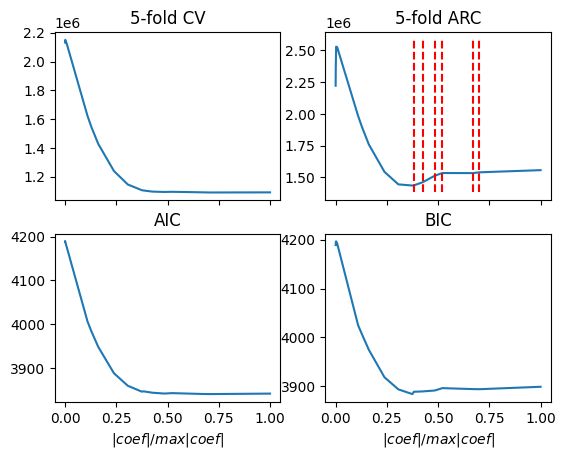

In [75]:
from sklearn.model_selection import train_test_split
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(X_sorted, y, test_size=0.2)
df = cv_vs_cd_exact_ls(X_train,y_train, 10)

fig,ax = plt.subplots(2,2,sharex=True)
ax[0,0].plot(df.frac, df.cv_error)
ax[0,1].plot(df.frac,df.cx_error)
ax[1,0].plot(df.frac,df.aic)
ax[1,1].plot(df.frac,df.bic)
ax[0, 0].set_title('5-fold CV')
ax[0, 1].set_title('5-fold ARC')
ax[1, 0].set_title('AIC')
ax[1, 1].set_xlabel('$|coef|/max|coef|$')
ax[1, 1].set_title('BIC')
ax[1, 0].set_xlabel('$|coef|/max|coef|$')
ymin, ymax =ax[0,1].get_ylim()
for i in df.frac[-7:-1]:
    ax[0,1].vlines(i, ymin, ymax, linestyle="dashed",color='red')